# Pruebas estrategia 1
- NW Estimator + ATR

In [27]:
!pip install pandas_ta

In [28]:
import sys
import os

# This adds the main project folder ("QUANT-DEV-UNVESTING") to the list of places
# Python looks for code. It goes one level up from the current working directory.
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt

def nadaraya_watson_estimator(source: pd.Series, length: int = 8, bandwidth: float = 8.0) -> pd.Series:
    """
    Calculates the Nadaraya-Watson Estimator using a Gaussian kernel.
    This is a non-parametric method to estimate a smooth line from noisy data.

    Args:
        source (pd.Series): The source data series (e.g., 'Close' prices).
        length (int): The lookback period for the kernel calculation.
        bandwidth (float): The bandwidth parameter for the Gaussian kernel, controlling smoothness.

    Returns:
        pd.Series: The smoothed Nadaraya-Watson Estimator line.
    """
    nwe = pd.Series(index=source.index, dtype=float)
    src_values = source.to_numpy()
    
    # Iterate through the source data to calculate the NWE value for each point
    for i in range(len(src_values)):
        if i < length - 1:
            nwe.iloc[i] = np.nan
            continue
            
        y_ = src_values[i - length + 1 : i + 1]
        
        sum_w = 0.0
        sum_wy = 0.0
        
        # Kernel regression calculation for the current point
        for k in range(length):
            # Gaussian kernel
            w = np.exp(-((k - (length - 1))**2) / (2 * bandwidth**2))
            sum_w += w
            sum_wy += y_[k] * w
            
        # The estimator is the weighted average
        nwe.iloc[i] = sum_wy / sum_w if sum_w != 0 else np.nan

    return nwe


def generate_nw_atr_signals(df: pd.DataFrame, 
                              nw_length: int = 32, 
                              nw_bandwidth: float = 8.0,
                              atr_length: int = 14, 
                              atr_multiplier: float = 2.5) -> pd.DataFrame:
    """
    Generates trading signals based on the change in direction of the Nadaraya-Watson estimator.
    It also calculates an ATR-based trailing stop-loss for reference during active trades.

    Args:
        df (pd.DataFrame): DataFrame with 'High', 'Low', 'Close' columns.
        nw_length (int): Lookback period for the Nadaraya-Watson estimator.
        nw_bandwidth (float): Bandwidth for the Nadaraya-Watson kernel.
        atr_length (int): Lookback period for the ATR calculation.
        atr_multiplier (float): Multiplier for the ATR to set the stop-loss distance.

    Returns:
        pd.DataFrame: The original DataFrame with added columns for indicators and signals.
    """
    if not all(col in df.columns for col in ['High', 'Low', 'Close']):
        raise ValueError("Input DataFrame must contain 'High', 'Low', and 'Close' columns.")

    # --- 1. Create a copy to avoid modifying the original DataFrame ---
    data = df.copy()

    # --- 2. Calculate Indicators ---
    # Nadaraya-Watson Estimator
    data['NWE'] = nadaraya_watson_estimator(data['Close'], length=nw_length, bandwidth=nw_bandwidth)

    # --- Manual ATR Calculation ---
    high_low = data['High'] - data['Low']
    high_close_prev = np.abs(data['High'] - data['Close'].shift(1))
    low_close_prev = np.abs(data['Low'] - data['Close'].shift(1))
    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
    data['ATR'] = tr.ewm(com=atr_length - 1, min_periods=atr_length).mean()
        
    # --- 3. Generate Signals based on NWE Direction Change ---
    # Calculate the direction of the NWE
    data['NWE_Direction'] = np.sign(data['NWE'].diff())
    data['Prev_NWE_Direction'] = data['NWE_Direction'].shift(1)
    
    # Generate signals based on direction change
    data['signal'] = 'hold'
    buy_conditions = (data['NWE_Direction'] > 0) & (data['Prev_NWE_Direction'] <= 0)
    sell_conditions = (data['NWE_Direction'] < 0) & (data['Prev_NWE_Direction'] >= 0)
    data.loc[buy_conditions, 'signal'] = 'buy'
    data.loc[sell_conditions, 'signal'] = 'sell'

    # --- 4. Calculate Trailing Stop-Loss for active positions (for plotting reference) ---
    data['trailing_stop'] = np.nan
    in_position = False
    highest_high_since_entry = 0.0

    for i in range(len(data)):
        current_signal = data['signal'].iloc[i]
        if current_signal == 'buy':
            in_position = True
            highest_high_since_entry = data['High'].iloc[i]
        elif current_signal == 'sell':
            in_position = False
            highest_high_since_entry = 0.0

        if in_position:
            highest_high_since_entry = max(highest_high_since_entry, data['High'].iloc[i])
            stop_level = highest_high_since_entry - (data['ATR'].iloc[i] * atr_multiplier)
            data.loc[data.index[i], 'trailing_stop'] = stop_level
                
    return data


[*********************100%***********************]  1 of 1 completed

--- Downloading data for NVDA from 2023-06-30 to 2025-06-30 ---
--- Generating signals for NVDA ---


--- Plotting results... ---


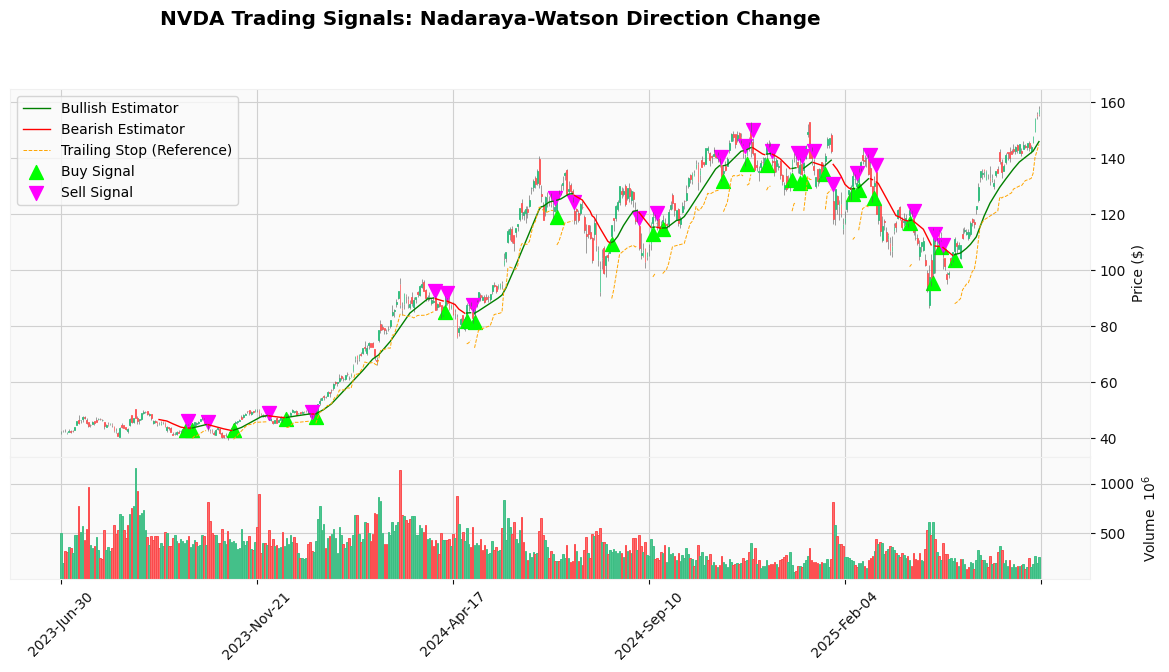

In [30]:
# --- 1. Download Data ---
today = pd.Timestamp.today().normalize()
start_date = today - pd.DateOffset(years=2)
ticker_symbol = 'NVDA'

print(f"--- Downloading data for {ticker_symbol} from {start_date.date()} to {today.date()} ---")
data = yf.download(ticker_symbol, start=start_date, end=today, multi_level_index=False)

# --- 2. Generate Signals ---
print(f"--- Generating signals for {ticker_symbol} ---")
signals_df = generate_nw_atr_signals(
    data,
    nw_length=50,
    nw_bandwidth=10.0,
    atr_length=14,
    atr_multiplier=3.5
)

# --- 3. Prepare Data for Plotting based on Estimator Direction ---
direction_filled = signals_df['NWE_Direction'].ffill()
signals_df['Bullish_NWE'] = signals_df['NWE'].where(direction_filled > 0)
signals_df['Bearish_NWE'] = signals_df['NWE'].where(direction_filled <= 0)

# Use the 'signal' column to place markers
signals_df['buy_marker'] = signals_df['Low'].where(signals_df['signal'] == 'buy', np.nan) * 0.98
signals_df['sell_marker'] = signals_df['High'].where(signals_df['signal'] == 'sell', np.nan) * 1.02

# --- 4. Visualize the Results with mplfinance ---
print("--- Plotting results... ---")

ap = [
    mpf.make_addplot(signals_df['Bullish_NWE'], label='Bullish Estimator', color='green', width=1.0),
    mpf.make_addplot(signals_df['Bearish_NWE'], label='Bearish Estimator', color='red', width=1.0),
    mpf.make_addplot(signals_df['trailing_stop'], label='Trailing Stop (Reference)', color='orange', linestyle='--', width=0.7),
    mpf.make_addplot(signals_df['buy_marker'], label='Buy Signal', type='scatter', marker='^', color='lime', markersize=100),
    mpf.make_addplot(signals_df['sell_marker'], label='Sell Signal', type='scatter', marker='v', color='fuchsia', markersize=100)
]

fig, axes = mpf.plot(signals_df, 
                        type='candle', 
                        style='yahoo',
                        title=f'{ticker_symbol} Trading Signals: Nadaraya-Watson Direction Change',
                        ylabel='Price ($)',
                        addplot=ap,
                        figsize=(15, 7),
                        volume=True,
                        panel_ratios=(3, 1),
                        returnfig=True)

axes[0].legend(loc='upper left')
plt.show()



In [31]:
signals_df

,Close,High,Low,Open,Volume,NWE,ATR,NWE_Direction,Prev_NWE_Direction,signal,trailing_stop,Bullish_NWE,Bearish_NWE,buy_marker,sell_marker
Date,,,,,,,,,,,,,,,
2023-06-30,42.275986,42.523834,41.475480,41.654370,501148000,NaN,NaN,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN
2023-07-03,42.386913,42.871616,42.176045,42.490849,198209000,NaN,NaN,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN
2023-07-05,42.290977,43.150445,42.059118,42.109086,323618000,NaN,NaN,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN
2023-07-06,42.077106,42.153060,41.320572,41.818267,303582000,NaN,NaN,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN
2023-07-07,42.476856,43.187421,42.154057,42.295968,355881000,NaN,NaN,NaN,NaN,hold,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-23,144.169998,144.779999,142.029999,142.500000,154308900,141.935013,3.825758,1.0,1.0,hold,132.809843,141.935013,NaN,NaN,NaN
2025-06-24,147.899994,147.960007,145.500000,145.559998,187566100,142.576576,3.823205,1.0,1.0,hold,134.578790,142.576576,NaN,NaN,NaN
2025-06-25,154.309998,154.449997,149.259995,149.270004,269146500,143.662985,4.017976,1.0,1.0,hold,140.387081,143.662985,NaN,NaN,NaN
